In [1]:
# notebook dependencies
%matplotlib inline
import matplotlib as mlp
mlp.rcParams['figure.dpi'] = 300

import pandas as pd
import numpy as np

# visualization libraries/modules
import matplotlib.pyplot as plt
import seaborn as sns

# plotly import
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"
sns.set()

# created module
import prepare
from prepare import get_curriculum_logs

from skimpy import clean_columns 

import env
from env import user, password, host, get_connection

In [2]:
# acquiring the codeup class logs

# generating the logs query
# query = '''
# SELECT lg.date,
# lg.time,
# lg.path as endpoint,
# lg.user_id,
# lg.ip as source_ip,
# lg.cohort_id,
# ct.name as cohort_name 
# FROM logs lg, cohorts ct
# WHERE lg.cohort_id = ct.id;
# '''

# creating the first url
# url = get_connection(user, password, host, "curriculum_logs")

# df_logs = pd.read_sql(query, url)
# df_logs.head()

,date,time,endpoint,user_id,source_ip,cohort_id,cohort_name
0,2018-01-26,09:55:03,/,1,97.105.19.61,8.0,Hampton
1,2018-01-26,09:56:02,java-ii,1,97.105.19.61,8.0,Hampton
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,97.105.19.61,8.0,Hampton
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,97.105.19.61,8.0,Hampton
4,2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,22.0,Teddy


In [3]:
# original shape 

# df_logs.shape

In [4]:
# creating a function to pull this query/data in the future

def get_curriculum_logs():

    # creating the corriculum logs url
    url = get_connection(user, password, host, "curriculum_logs")

    # creating the mysql query
    query = '''
            SELECT 
                lg.date,
                lg.time,
                lg.user_id,
                lg.cohort_id,
                ct.name AS cohort_name,
                lg.ip AS source_ip,
                lg.path AS endpoint
            FROM
                logs lg,
                cohorts ct
            WHERE
                lg.cohort_id = ct.id'''

    # creating the df
    df = pd.read_sql(query, url)

    # setting user/cohort id to proper data type
    df[["user_id", "cohort_id"]] = df[["user_id", "cohort_id"]].astype(object)

    # combining date and time & dropping previous columns
    df["datetime"] = df["date"] + " " + df["time"]
    df = df.drop(columns = ["date", "time", "cohort_id"])

    # converting datetime column to proper pd.datetime 
    df["datetime"] = pd.to_datetime(df["datetime"])

    # setting the date column to index
    df = df.set_index("datetime").rename_axis(None).sort_index()
    
    # creating a day column 
    df["day"] = df.index.strftime("%A")

    # creating a month column 
    df["month"] = df.index.strftime("%B")

    # cleaning remaining column names
    df = clean_columns(df)

    # print the new merged df shape
    print(f'df shape: {df.shape}')

    # returning the codeup "curriculum" dataframe
    return df

In [5]:
# let's try the function

df = get_curriculum_logs()
df.head() # checks out!

df shape: (847330, 6)


,user_id,cohort_name,source_ip,endpoint,day,month
2018-01-26 09:55:03,1,Hampton,97.105.19.61,/,Friday,January
2018-01-26 09:56:02,1,Hampton,97.105.19.61,java-ii,Friday,January
2018-01-26 09:56:05,1,Hampton,97.105.19.61,java-ii/object-oriented-programming,Friday,January
2018-01-26 09:56:06,1,Hampton,97.105.19.61,slides/object_oriented_programming,Friday,January
2018-01-26 09:56:24,2,Teddy,97.105.19.61,javascript-i/conditionals,Friday,January


In [6]:
# caching the dataframe for faster referencing

# df.to_csv("/Users/mijailmariano/codeup-data-science/anamoly-detection-exercises/curriculum_logs.csv", index = False)

In [7]:
# checking the df information 

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 847330 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      847330 non-null  object
 1   cohort_name  847330 non-null  object
 2   source_ip    847330 non-null  object
 3   endpoint     847329 non-null  object
 4   day          847330 non-null  object
 5   month        847330 non-null  object
dtypes: object(6)
memory usage: 45.3+ MB


In [8]:
# Groupby method to view total number of visited pages by day and per user_id & cohort

pd.DataFrame(df.groupby([df.index, 'user_id', 'cohort_name'])['endpoint'].agg('count'))

,,,endpoint
,user_id,cohort_name,
2018-01-26 09:55:03,1,Hampton,1
2018-01-26 09:56:02,1,Hampton,1
2018-01-26 09:56:05,1,Hampton,1
2018-01-26 09:56:06,1,Hampton,1
2018-01-26 09:56:24,2,Teddy,1
...,...,...,...
2021-04-21 16:41:51,875,Marco,1
2021-04-21 16:42:02,64,Staff,1
2021-04-21 16:42:09,64,Staff,1


In [9]:
# Is it possible to identify the user_id of a staff member?

cohort_lst = df["cohort_name"].sort_values().unique()
cohort_lst

array(['Andromeda', 'Apex', 'Apollo', 'Arches', 'Badlands', 'Bash',
       'Bayes', 'Betelgeuse', 'Ceres', 'Curie', 'Darden', 'Deimos',
       'Denali', 'Easley', 'Europa', 'Everglades', 'Florence', 'Fortuna',
       'Franklin', 'Ganymede', 'Glacier', 'Hampton', 'Hyperion', 'Ike',
       'Joshua', 'Jupiter', 'Kalypso', 'Kings', 'Lassen', 'Luna',
       'Mammoth', 'Marco', 'Neptune', 'Niagara', 'Oberon', 'Olympic',
       'Pinnacles', 'Quincy', 'Sequoia', 'Staff', 'Teddy', 'Ulysses',
       'Voyageurs', 'Wrangell', 'Xanadu', 'Yosemite', 'Zion'],
      dtype=object)

In [10]:
# Identify students who are accessing our curriculum pages beyond the end of their time at Codeup

----
### **Exercise: Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2**

In [11]:
# first: creating the resampling by day

daily_pages = pd.DataFrame(df['endpoint'].resample("D").count()).rename(columns = {'endpoint': 'pages_visited'})
daily_pages

,pages_visited
2018-01-26,533
2018-01-27,230
2018-01-28,168
2018-01-29,783
2018-01-30,614
...,...
2021-04-17,430
2021-04-18,651
2021-04-19,2156
2021-04-20,1921


In [12]:
# plotting the daily pages visited

px.line(daily_pages, title = "Daily Pages Visited", labels = {"variable": "legend"}, height = 500, width = 1200)

In [13]:
# setting the window
span = 30

# setting the midband
midband = daily_pages.ewm(span = span).mean().round(2)
midband.head()

,pages_visited
2018-01-26,533.00
2018-01-27,376.45
2018-01-28,302.28
2018-01-29,434.74
2018-01-30,475.53


In [14]:
# computing 'exponential' standard deviation

stdev = daily_pages.ewm(span = span).std()
stdev.head()

,pages_visited
2018-01-26,NaN
2018-01-27,214.253355
2018-01-28,192.738756
2018-01-29,292.489456
2018-01-30,262.780177


In [15]:
# computing upper and lower bands

upper_band = midband + (stdev*2)
lower_band = midband - (stdev*2)

lower_band, upper_band

(            pages_visited
 2018-01-26            NaN
 2018-01-27     -52.056709
 2018-01-28     -83.197512
 2018-01-29    -150.238913
 2018-01-30     -50.030353
 ...                   ...
 2021-04-17    -170.182324
 2021-04-18    -201.992330
 2021-04-19    -163.661853
 2021-04-20    -106.593111
 2021-04-21     -80.899682
 
 [1182 rows x 1 columns],
             pages_visited
 2018-01-26            NaN
 2018-01-27     804.956709
 2018-01-28     687.757512
 2018-01-29    1019.718913
 2018-01-30    1001.090353
 ...                   ...
 2021-04-17    2797.622324
 2021-04-18    2743.912330
 2021-04-19    2819.781853
 2021-04-20    2839.233111
 2021-04-21    2780.079682
 
 [1182 rows x 1 columns])

In [16]:
# combining lower and upper bands

bollinger_bands = pd.concat([lower_band, upper_band], axis = 1).round(2)
bollinger_bands.head()

,pages_visited,pages_visited
2018-01-26,NaN,NaN
2018-01-27,-52.06,804.96
2018-01-28,-83.20,687.76
2018-01-29,-150.24,1019.72
2018-01-30,-50.03,1001.09


In [17]:
# bringing it all together

bb_df = pd.concat([daily_pages, midband, bollinger_bands], axis = 1).round(2)
bb_df.columns = ['daily_pages', 'midband', 'lower_band', 'upper_band']
bb_df.head()

,daily_pages,midband,lower_band,upper_band
2018-01-26,533,533.00,NaN,NaN
2018-01-27,230,376.45,-52.06,804.96
2018-01-28,168,302.28,-83.20,687.76
2018-01-29,783,434.74,-150.24,1019.72
2018-01-30,614,475.53,-50.03,1001.09


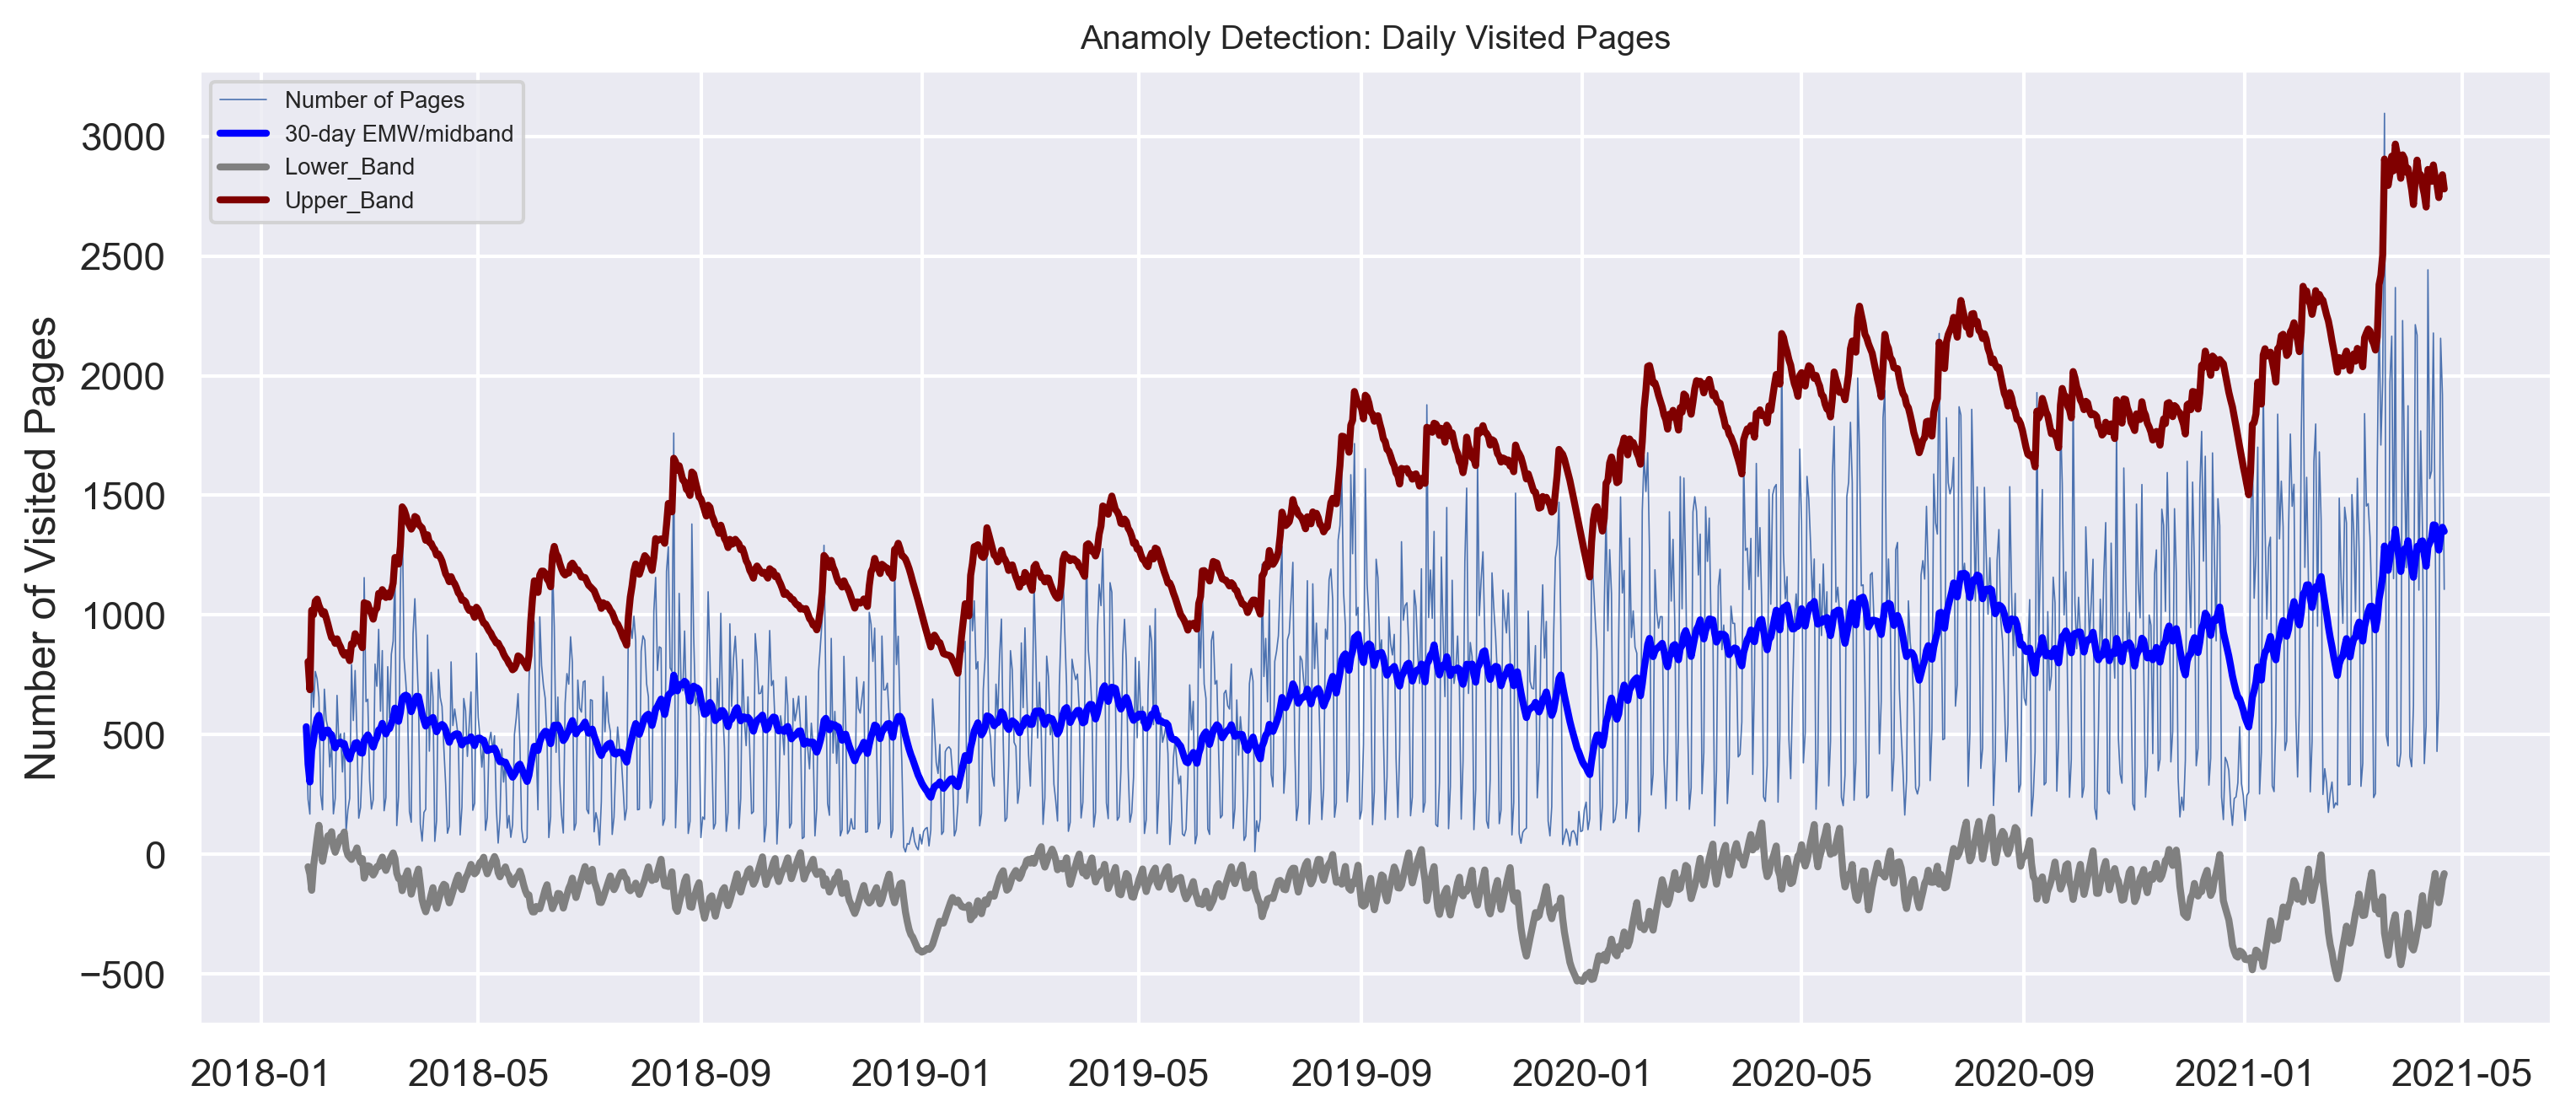

In [18]:
# plotting the bollinger bands for daily ip/page visit by user

fig, ax = plt.subplots(figsize = (12, 5))

sns.set(font_scale = 0.6)

ax.plot(bb_df.index, bb_df["daily_pages"], label = "Number of Pages", linewidth = .4)
ax.plot(bb_df.index, bb_df["midband"], label = "30-day EMW/midband", color = 'blue', linewidth = 2)
ax.plot(bb_df.index, bb_df["lower_band"], label = "Lower_Band", color = "gray", linewidth = 2)
ax.plot(bb_df.index, bb_df["upper_band"], label = "Upper_Band", color = "maroon", linewidth = 2)

# place legend in best graph location
ax.legend(loc = "best")
ax.set_ylabel("Number of Visited Pages")


sns.set_theme("paper")
plt.title("Anamoly Detection: Daily Visited Pages")
plt.show()

In [19]:
# computing the relative band percentage difference "%b"
# visualize the last record in the dataset

bb_df.iloc[-1]

daily_pages    1107.00
midband        1349.59
lower_band      -80.90
upper_band     2780.08
Name: 2021-04-21 00:00:00, dtype: float64

In [20]:
# returning the value of the last record

last_measure = bb_df.iloc[-1].daily_pages
print(f'Total number of pages (last df record): {last_measure}')

Total number of pages (last df record): 1107.0


In [21]:
# returning the lower band value on the last date

last_lower_band = bb_df.iloc[-1].lower_band
print(f'Last lower band value: {last_lower_band}') # notice that this value represent negative pages visited??

Last lower band value: -80.9


In [22]:
# returning the upper band value on the last date

last_upper_band = bb_df.iloc[-1].upper_band
print(f'Last upper band value: {last_upper_band}')

Last upper band value: 2780.08


In [23]:
# computing the relative band percentage difference or "%b"

last_pct_b = (last_measure - last_lower_band)/(last_upper_band - last_lower_band)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.42


In [24]:
# checking the dataframe head

bb_df.head()

,daily_pages,midband,lower_band,upper_band
2018-01-26,533,533.00,NaN,NaN
2018-01-27,230,376.45,-52.06,804.96
2018-01-28,168,302.28,-83.20,687.76
2018-01-29,783,434.74,-150.24,1019.72
2018-01-30,614,475.53,-50.03,1001.09


In [25]:
# adding a new column that shows the %b for every record in the dataset 
# (except the first because there are no bollinger bands available for that one record)

bb_df["percent_b"] = round((bb_df["daily_pages"] - bb_df["lower_band"]) / (bb_df["upper_band"] - bb_df["lower_band"]), 3)

# checking the dataframe with new column 
bb_df.head()

,daily_pages,midband,lower_band,upper_band,percent_b
2018-01-26,533,533.00,NaN,NaN,NaN
2018-01-27,230,376.45,-52.06,804.96,0.329
2018-01-28,168,302.28,-83.20,687.76,0.326
2018-01-29,783,434.74,-150.24,1019.72,0.798
2018-01-30,614,475.53,-50.03,1001.09,0.632


In [26]:
# checking where bollinger percentage difference is greater > 1 

bb_df[bb_df["percent_b"] >= 1]

,daily_pages,midband,lower_band,upper_band,percent_b
2018-02-27,1156,475.92,-99.47,1051.31,1.091
2018-03-20,1460,649.89,-151.89,1451.67,1.005
2018-05-30,1028,375.09,-220.91,971.09,1.048
2018-07-23,1026,426.69,-143.97,997.35,1.025
2018-08-17,1760,748.53,-157.58,1654.64,1.058
2018-11-08,1291,559.03,-130.47,1248.53,1.031
2019-01-28,1232,446.17,-273.37,1165.71,1.046
2019-07-08,1212,451.41,-260.52,1163.34,1.034
2019-10-07,1878,795.15,-193.86,1784.16,1.047
2020-07-16,2176,1007.53,-124.74,2139.80,1.016


----
### plot the access activity of these students